## Introduction¶

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

easy to use and interpret,
computationally efficient,
theoretically well-founded,
resistant to overfitting, and,
able to detect any kind of relationship

## Mutual Information and What it Measures

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

## Interpreting Mutual Information Scores¶
The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)





In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_csv("Automobile_data.csv")
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding.

In [3]:
X = df.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

y = X.pop("price")

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int



Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
print(len(discrete_features))
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

25


make                 2.455364
bore                 1.959605
curb-weight          1.635125
peak-rpm             1.483647
highway-mpg          1.064862
compression-ratio    0.698664
drive-wheels         0.542592
num-of-doors         0.167563
engine-location      0.065343
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

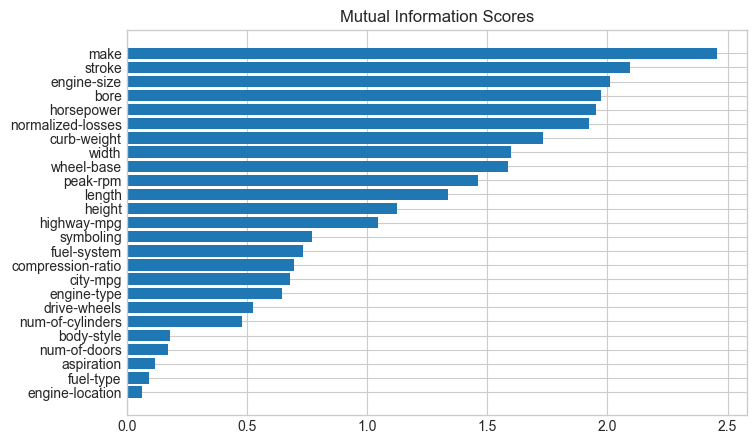

In [31]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring curb_weight feature exhibits a strong relationship with price, the target.

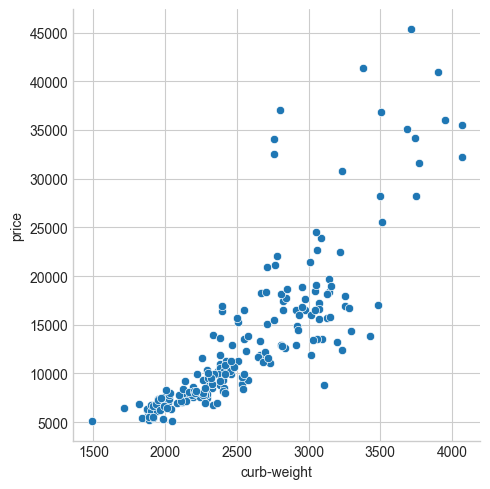

In [51]:
sns.relplot(x="curb-weight", y="price", data=df, height=5);

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

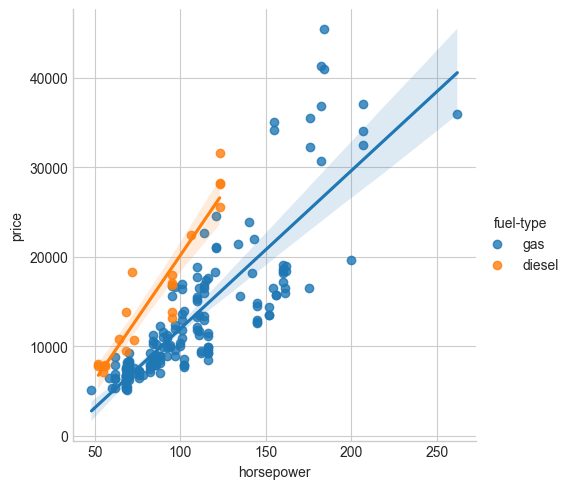

In [49]:

df.head()


df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')


sns.lmplot(x="horsepower", y="price", hue="fuel-type", data=df);

Data visualization is a great addition to your feature-engineering toolbox. Along with utility metrics like mutual information, visualizations like these can help you discover important relationships in your data. 